###DCGAN

## Task 1: setting the google runtime

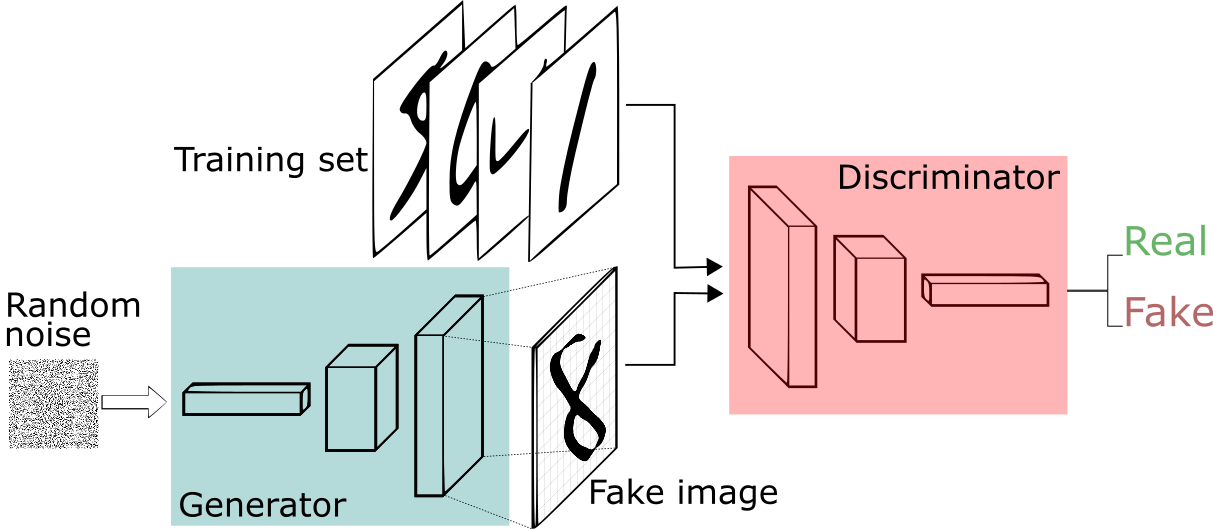

### setting up the environment changing runtime GPU and connecting

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
torch.manual_seed(42)
from tqdm import tqdm
from tqdm.notebook import tqdm

##configurations

In [2]:
device = 'cuda' # this will be used to transfer images into GPU
batch_size = 128
noise_dim = 64
#optimizers parameter
lr =0.0002 # learning rate
beta_1 = 0.5
beta_2 = 0.99

#training variable
epochs = 20

##Task 3: Load MNIST handwritten dataset


In [3]:
from torchvision import datasets, transforms as T

In [4]:
train_augs = T.Compose([T.RandomRotation((-20,+20)),T.ToTensor()])

In [5]:
trainset = datasets.MNIST('MNIST/',download= True, train = True, transform= train_augs)

100%|██████████| 9912422/9912422 [00:00<00:00, 304845261.10it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 30846879.00it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 167002110.42it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14059430.83it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



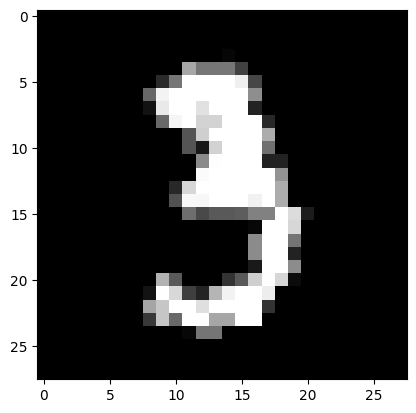

In [6]:
image,label = trainset[10]
plt.imshow(image.squeeze(),cmap= 'gray')

In [7]:
print("The let of the dataset:",len(trainset))

The let of the dataset: 60000


##Task 4: load data set into batches

In [8]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [9]:
trainloader= DataLoader(trainset,batch_size= batch_size, shuffle=True)
print("The batchsize:", len(trainloader))

The batchsize: 469


In [10]:
dataiter = iter(trainloader)
images,_= next(dataiter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [11]:
def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

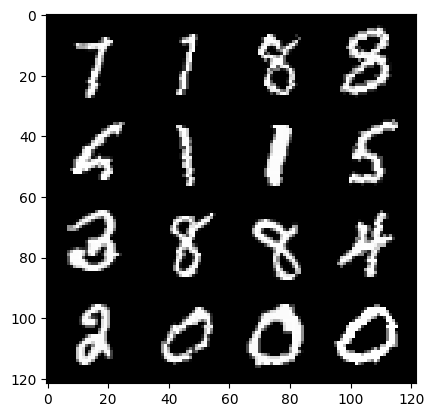

In [12]:
show_tensor_images( images, num_images= 16)

## create discriminator network

In [13]:
from torch import nn
from torchsummary import summary
from torch.nn.modules.activation import LeakyReLU


In [14]:
def get_dis_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )


In [15]:
import torch
import torch.nn as nn

def get_dis_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.block_1 = get_dis_block(1, 16, (3, 3), 2)
        self.block_2 = get_dis_block(16, 32, (5, 5), 2)
        self.block_3 = get_dis_block(32, 64, (5, 5), 2)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=64, out_features=1)

    def forward(self, images):
        x1 = self.block_1(images)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)

        x4 = self.flatten(x3)
        x5 = self.linear(x4)

        return x5

D = Discriminator()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

D.to(device)

input_size = (1, 28, 28)
summary(D, input_size)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

## create generator network

In [16]:
import torch.nn as nn

def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block=False):
    if final_block:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.Tanh()
        )
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(0.2)
        )

In [17]:
import torch

class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()

        self.noise_dim = noise_dim
        self.block_1 = get_gen_block(noise_dim, 256, (3, 3), 2)
        self.block_2 = get_gen_block(256, 128, (4, 4), 1)
        self.block_3 = get_gen_block(128, 64, (3, 3), 2)
        self.block_4 = get_gen_block(64, 1, (4, 4), 2, final_block=True)

    def forward(self, p_noise_vec):
        # Reshape: (bs, noise_dim) -> (bs, noise_dim, 1, 1)
        x = p_noise_vec.view(-1, self.noise_dim, 1, 1)
        x1 = self.block_1(x)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        x4 = self.block_4(x3)
        return x4

# Assuming you have defined the `noise_dim` and `input_size` appropriately
G = Generator(noise_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G.to(device)
summary(G, input_size=(1, noise_dim))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [18]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

## create loss functions and load optimizers

In [19]:
#Real loss
def Real_loss(disc_pred):# our discriminator prediction is without sigmoid actvation function
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.ones_like(disc_pred)
    loss = criterion(disc_pred,ground_truth)
    return loss

# fake loss
def Fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred,ground_truth)
  return loss

In [20]:
D_opt = torch.optim.Adam(D.parameters(),lr=lr, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(D.parameters(), lr=lr, betas = (beta_1,beta_2))

##create training loop to train gan

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs : 20 | D_loss : 0.001507465010767044 | G_loss : 0.0015516985199853046


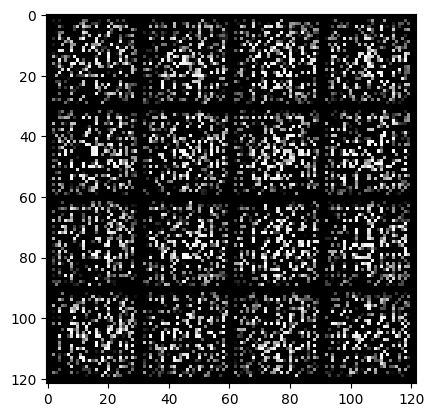

In [21]:
for i in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0

    for real_image, _ in tqdm(trainloader):
        real_image = real_image.to(device)
        noise = torch.randn(batch_size, noise_dim, device=device)


# find loss and update weight for D
D_opt.zero_grad()

fake_image = G(noise)
D_pred =  D(fake_image)
D_Fake_loss = Fake_loss(D_pred)

D_pred = D(real_image)
D_Real_loss = Real_loss(D_pred)

D_loss = (D_Fake_loss+D_Real_loss)/2
total_d_loss += D_loss.item()
D_loss.backward()
D_opt.step()

#find loss and update weight for G

G_opt.zero_grad()
noise = torch.randn(batch_size,noise_dim,device=device)
fake_image = G(noise)
D_pred =  D(fake_image)
G_loss = Real_loss(D_pred)
total_g_loss += G_loss.item()

G_loss.backward()
G_opt.step()

avg_d_loss = total_d_loss/ len(trainloader)
avg_g_loss = total_g_loss/ len(trainloader)

print("Epochs : {} | D_loss : {} | G_loss : {}".format(i+1, avg_d_loss, avg_g_loss))

show_tensor_images(fake_image)